### Generate example single units which are correlated to belief state value during cross fixation, stimulus onset periods

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
from scipy import stats
import warnings
from scipy.ndimage import gaussian_filter1d
import seaborn as sns

warnings.filterwarnings('ignore')

### Visualization func

In [3]:
SMOOTH = 1
num_bins = 10
mode = "FiringRate"
plt.rcParams.update({'font.size': 14})


def visualize_correlations(row, prev_response_cond=None):
    session = row.session

    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_beliefs_per_session(beh, session)
    beh = behavioral_utils.get_prev_choice_fbs(beh)
    out, bins = pd.cut(beh["BeliefStateValue"], 10, labels=False, retbins=True)
    beh["BeliefStateValueBin"] = out
    beh["BeliefStateValueLabel"] = bins[out]
    if prev_response_cond: 
        sub_beh = beh[beh.PrevResponse == prev_response_cond]
    else: 
        sub_beh = beh

    fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"

    frs = pd.read_pickle(fr_path)
    frs = frs[frs.UnitID == row.UnitID]
    agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()


    fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey="row")
    ax = axs[0, 0]
    sub_merged = pd.merge(frs, sub_beh, on="TrialNumber")
    sub_merged["Time to Cross Fixation"] = sub_merged["TimeBins"] - 0.5
    sns.lineplot(sub_merged, x="Time to Cross Fixation", y="FiringRate", hue="BeliefStateValueLabel", ax=ax)
    ax.set_ylabel("Firing Rate")

    ax = axs[0, 1]
    full_merged = pd.merge(frs, beh, on="TrialNumber")
    full_merged["Time to Cross Fixation"] = full_merged["TimeBins"] - 0.5
    sns.lineplot(full_merged, x="Time to Cross Fixation", y="FiringRate", hue="PrevResponse", ax=ax)
    ax.set_ylabel("Firing Rate")

    ax = axs[1, 0]
    sub_agg_merged = pd.merge(agg, sub_beh, on="TrialNumber")
    slope, intercept, r_value, p_value, std_err = stats.linregress(sub_agg_merged["BeliefStateValue"], sub_agg_merged[mode])
    ax.scatter(sub_agg_merged["BeliefStateValue"], sub_agg_merged[mode], alpha=0.15, color="black")
    ax.plot(sub_agg_merged["BeliefStateValue"], sub_agg_merged["BeliefStateValue"] * slope + intercept, color="black", linewidth=2)
    ax.set_xlabel("BeliefStateValue")
    ax.set_ylabel(f"Firing Rate")
    axs[0, 0].set_title(f"Ex. {row.structure_level2} unit, r: {r_value:.3f}, p: {p_value:.3E}")

    ax = axs[1, 1]
    agg_merged = pd.merge(agg, beh, on="TrialNumber")
    sns.barplot(agg_merged, x="PrevResponse", y="FiringRate", ax=ax)
    axs[0, 0].set_title(f"Ex. {row.structure_level2} unit, r: {r_value:.3f}, p: {p_value:.3E}")

    fig.tight_layout()

### Look at units with the highest correlations to belief state value

In [4]:
correlations = pd.read_pickle("/data/patrick_res/glm_2/belief_state_value_correlations.pickle")
SESSIONS_PATH = "/data/patrick_res/sessions/SA/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
positions = spike_utils.get_unit_positions(sessions)
correlations = pd.merge(correlations, positions, on=["PseudoUnitID", "session", "UnitID"])
correlations["r_mag"] = correlations.r_value.abs()
top = correlations.sort_values(by="r_mag", ascending=False)[:5]

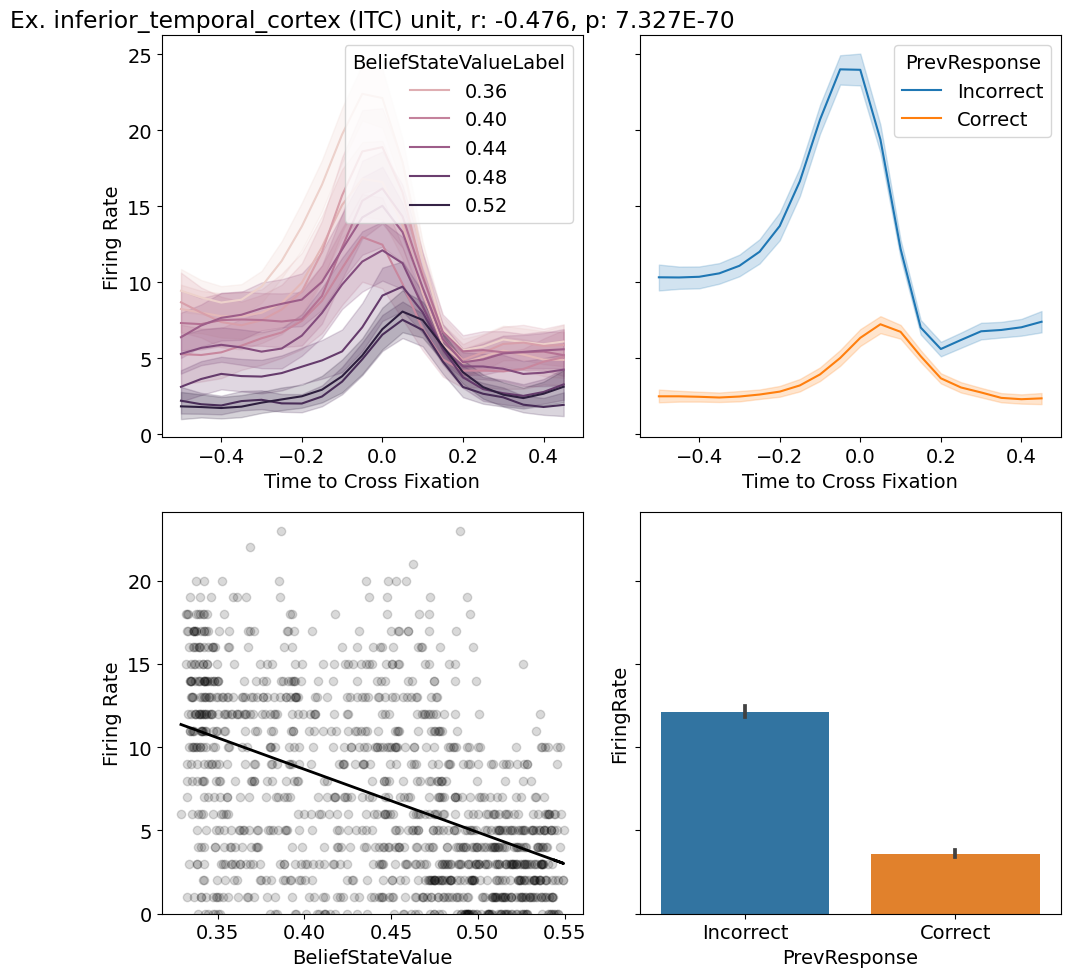

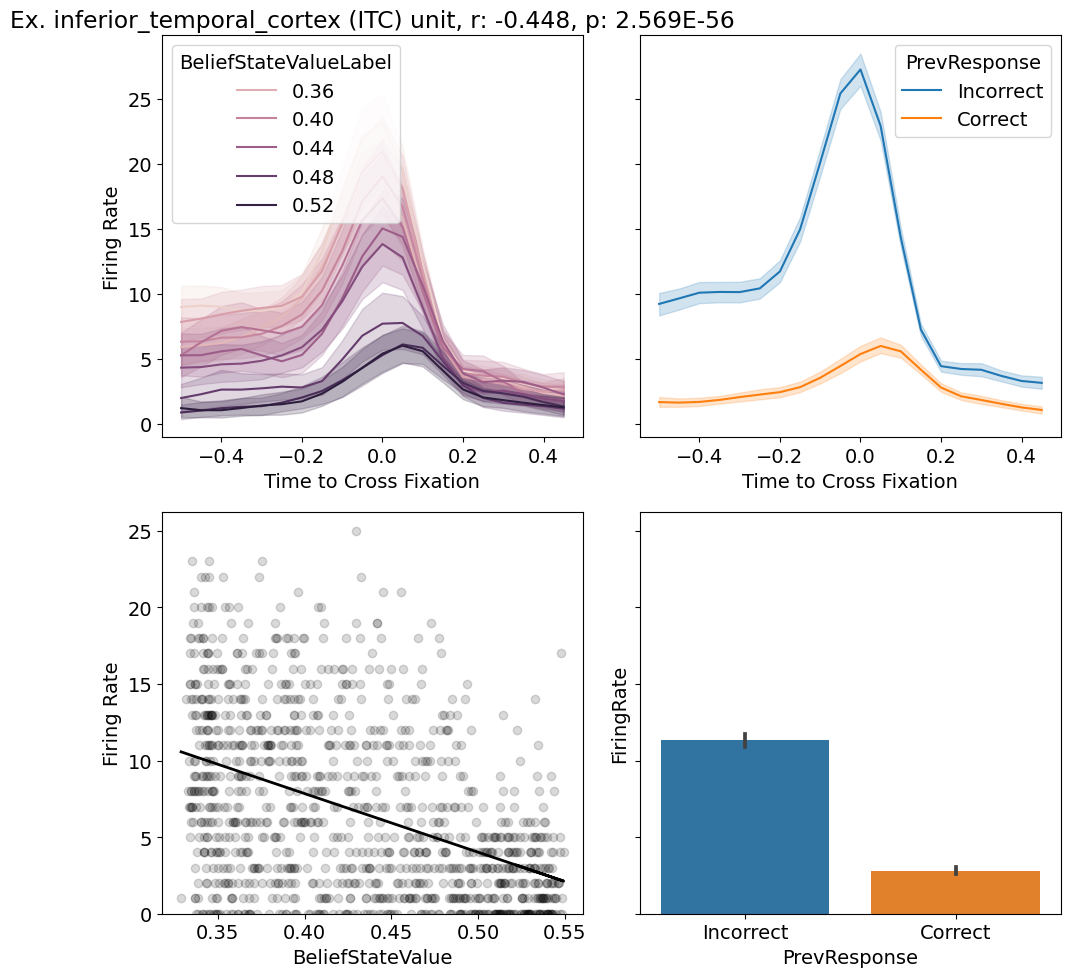

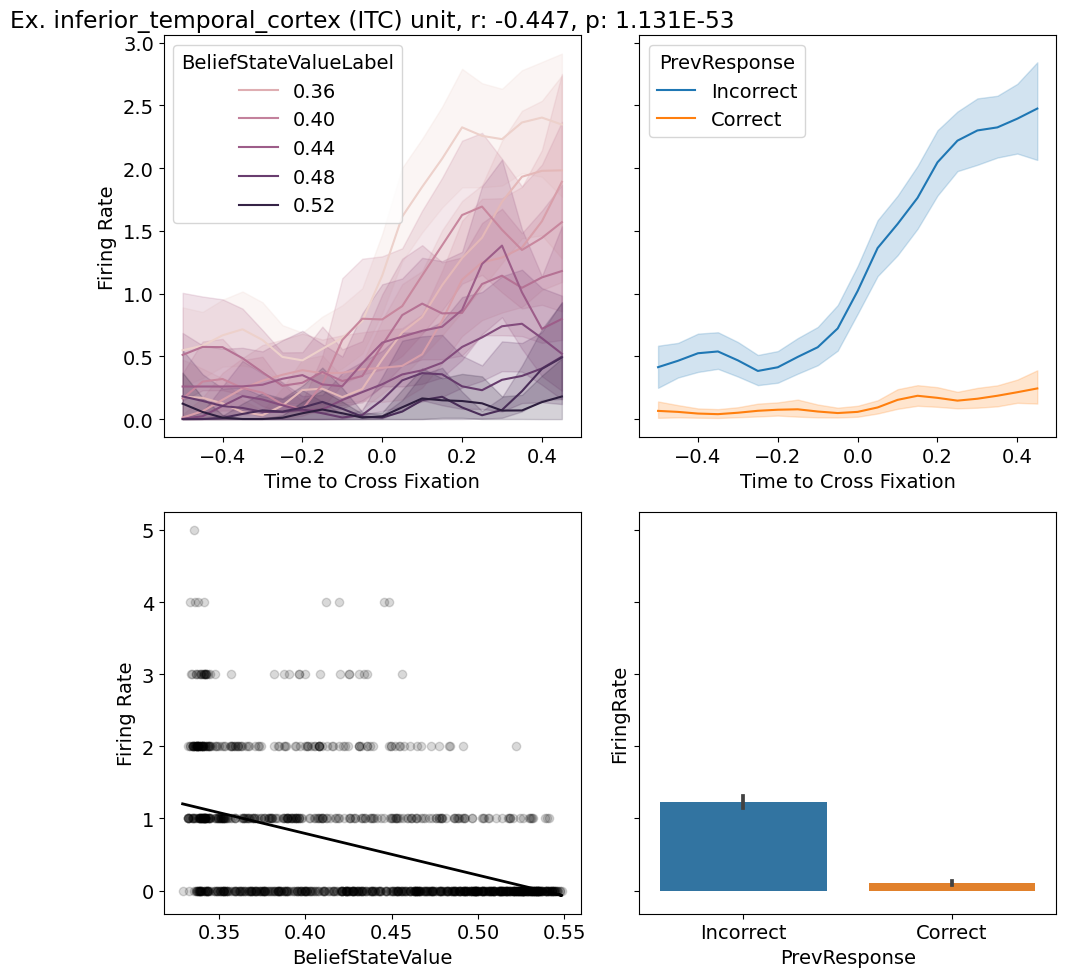

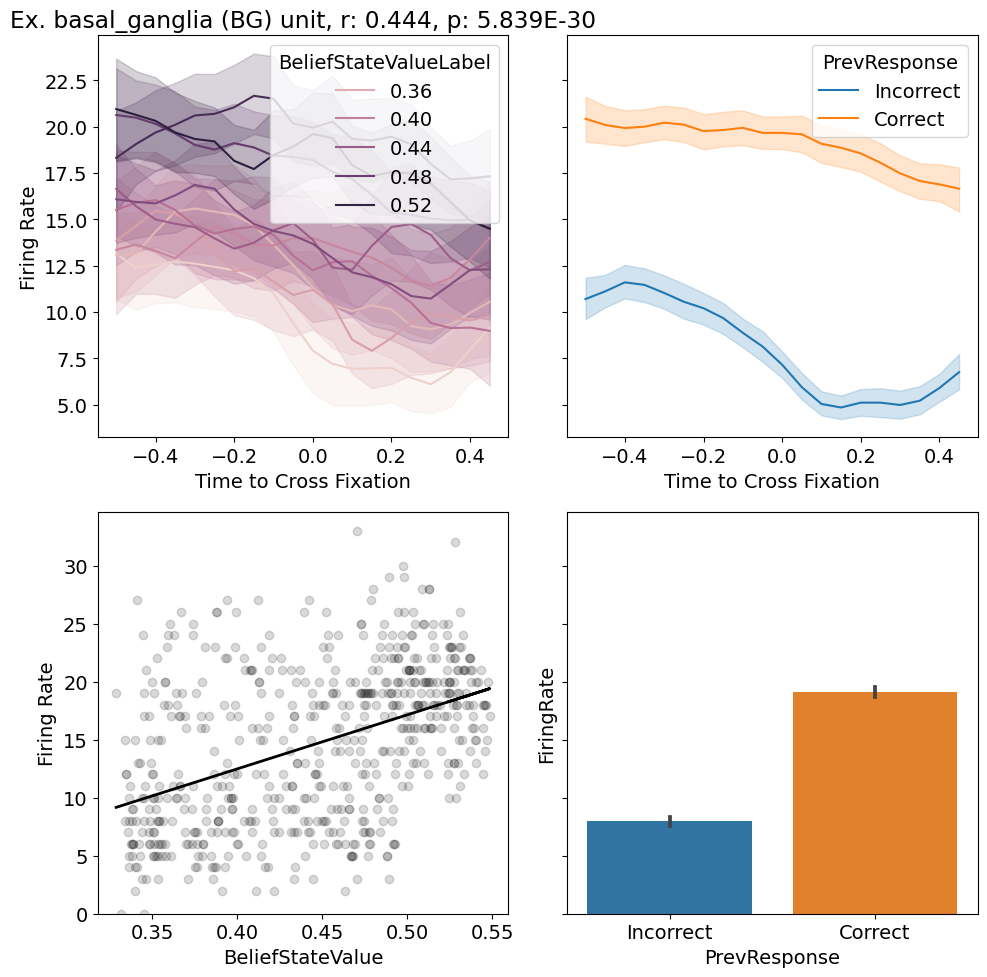

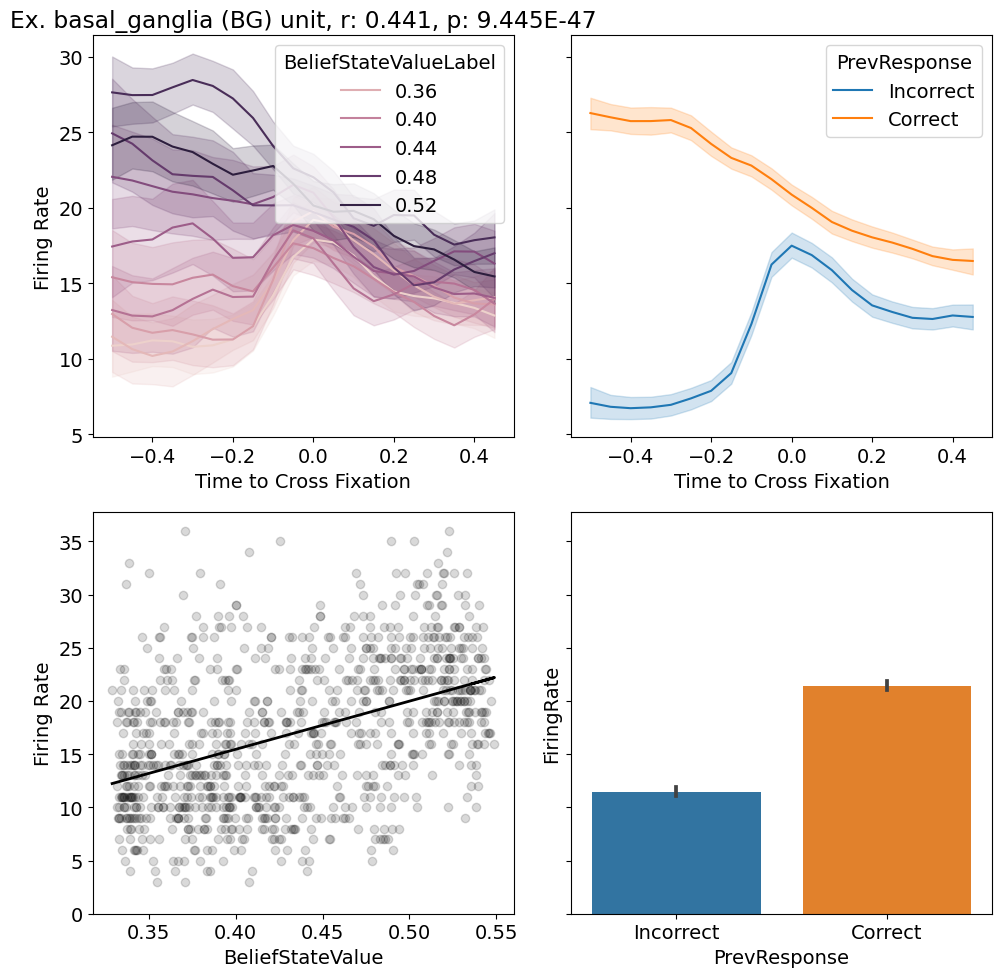

In [19]:
top = correlations.sort_values(by="r_mag", ascending=False)[:5]
# top_20 = merged[(merged.structure_level2 == "inferior_temporal_cortex (ITC)") & ()]
for i, row in top.iterrows():
    visualize_correlations(row)

### Look at units with high correlation, conditioned on previous trial being correct

In [20]:
correlations = pd.read_pickle("/data/patrick_res/glm_2/belief_state_value_correlations_cor.pickle")
correlations = pd.merge(correlations, positions, on=["PseudoUnitID", "session", "UnitID"])
correlations["r_mag"] = correlations.r_value.abs()

In [21]:
correlations.sort_values(by="r_mag", ascending=False)[:5][["PseudoUnitID", "r_value", "structure_level2"]]

PseudoUnitID   r_value                     structure_level2
645    2018080334  0.355585                   basal_ganglia (BG)
211    2018080115 -0.340883  lateral_prefrontal_cortex (lat_PFC)
126    2018100805 -0.286727      anterior_cingulate_gyrus (ACgG)
589    2018092506  0.283772      anterior_cingulate_gyrus (ACgG)
43     2018070943 -0.281489                   basal_ganglia (BG)

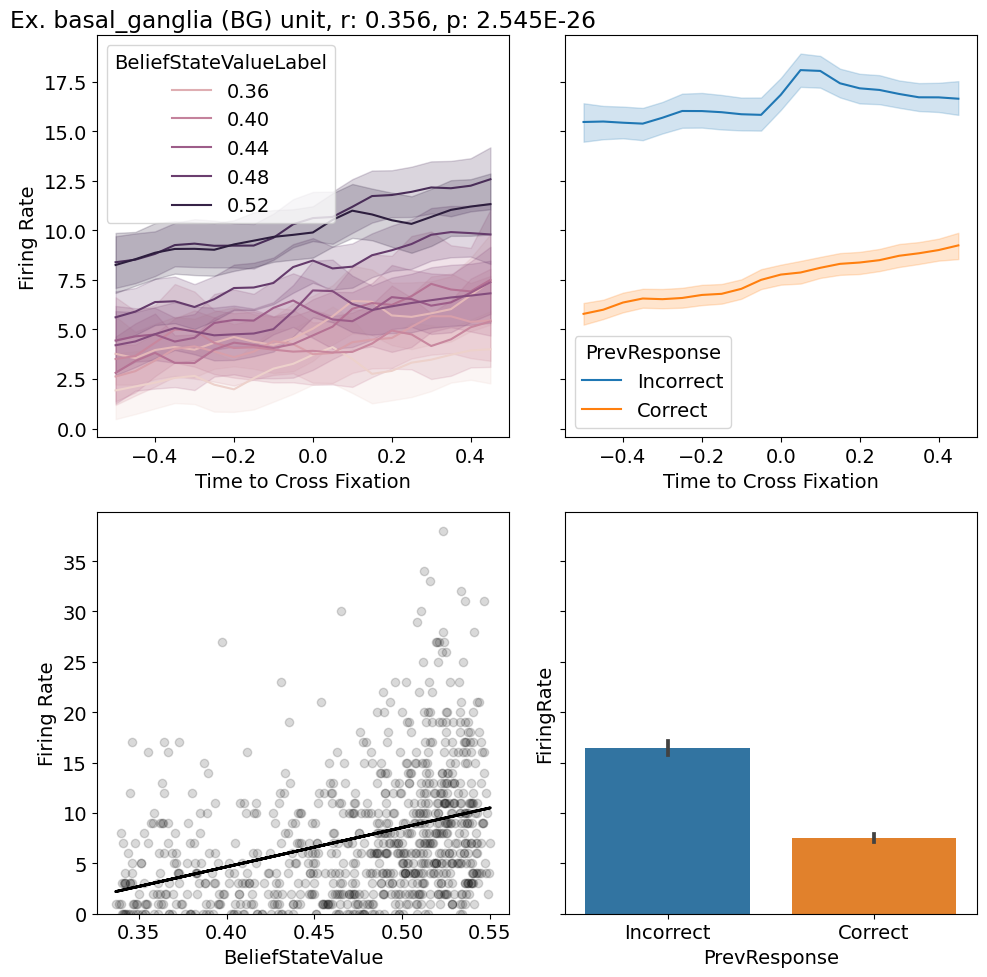

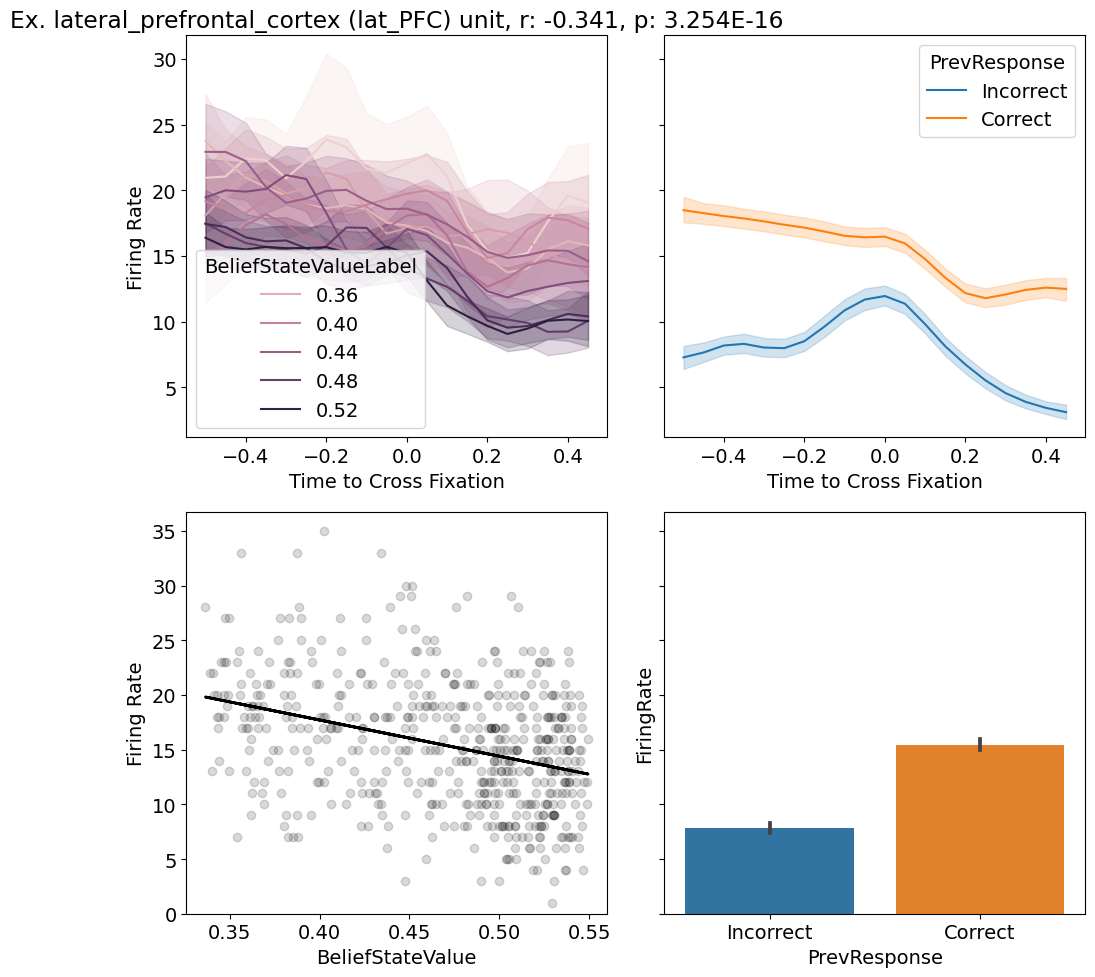

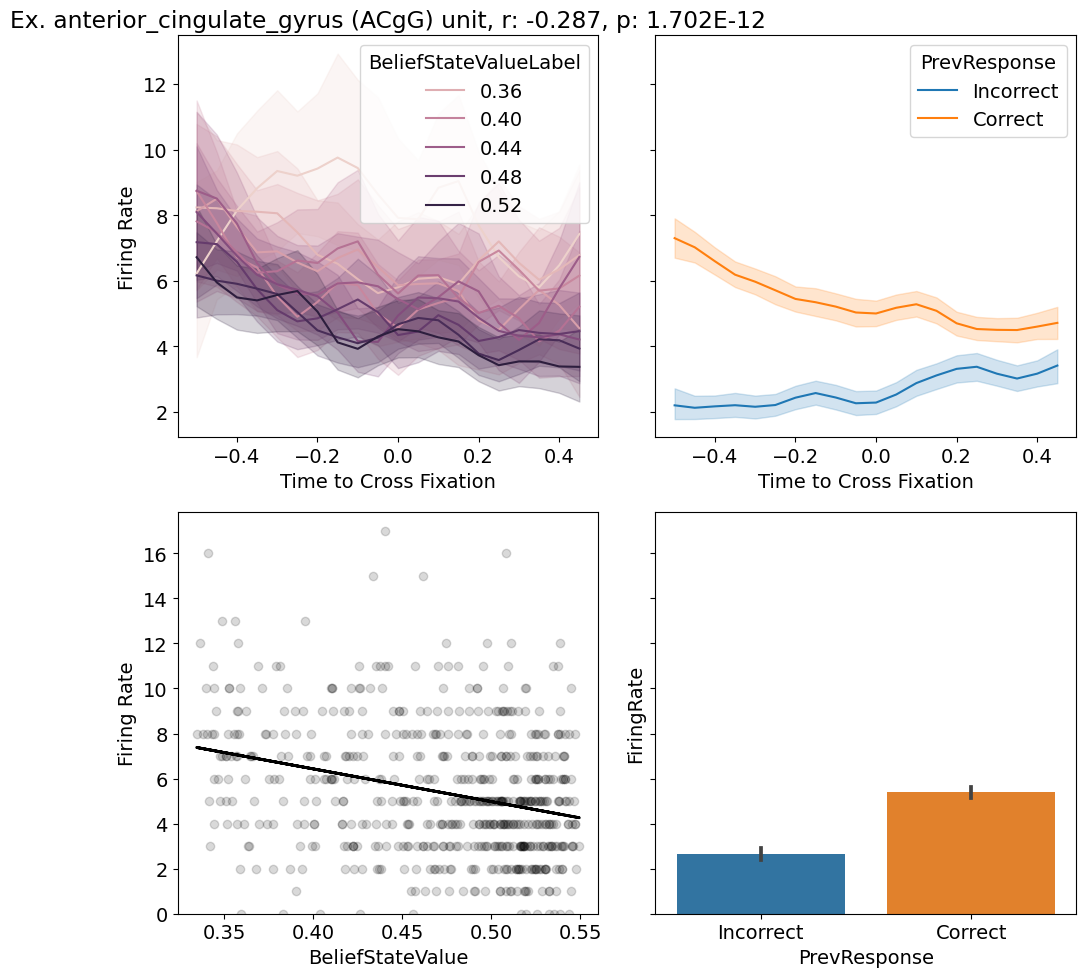

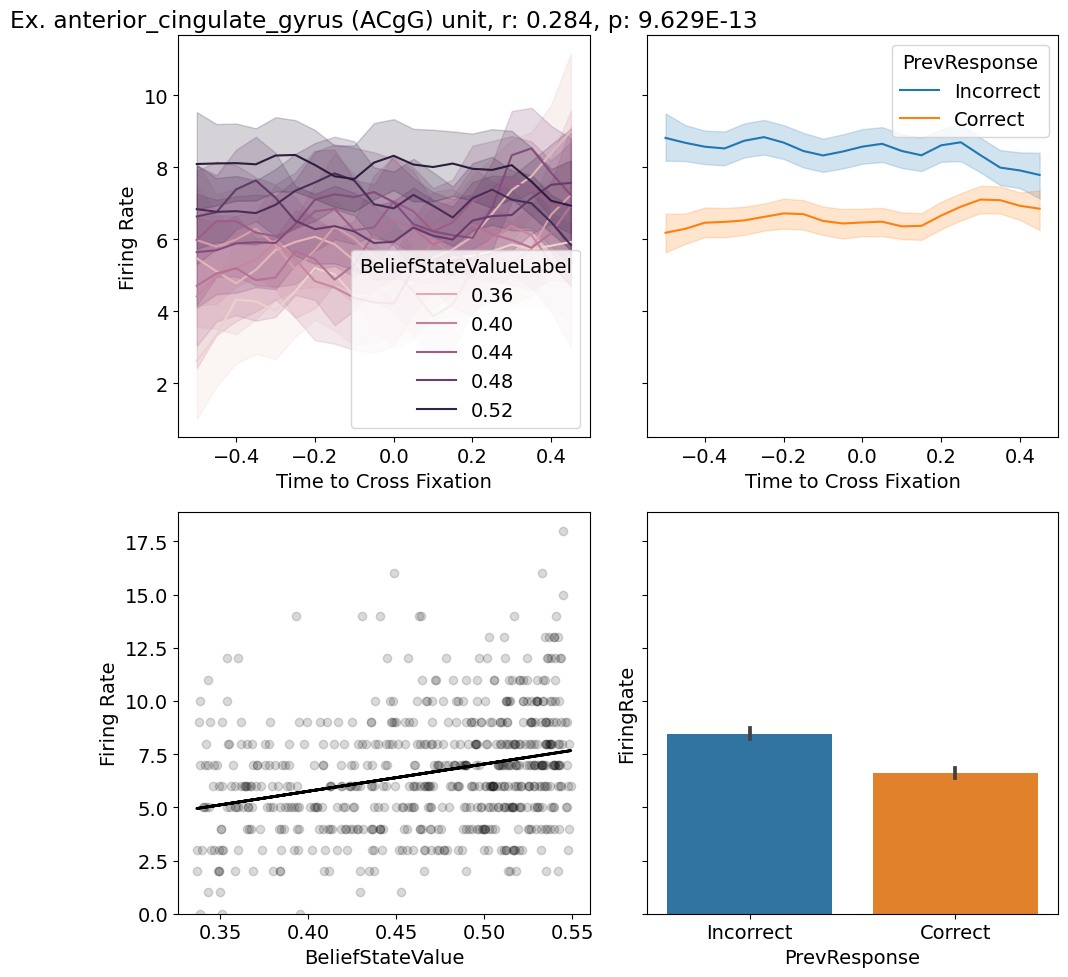

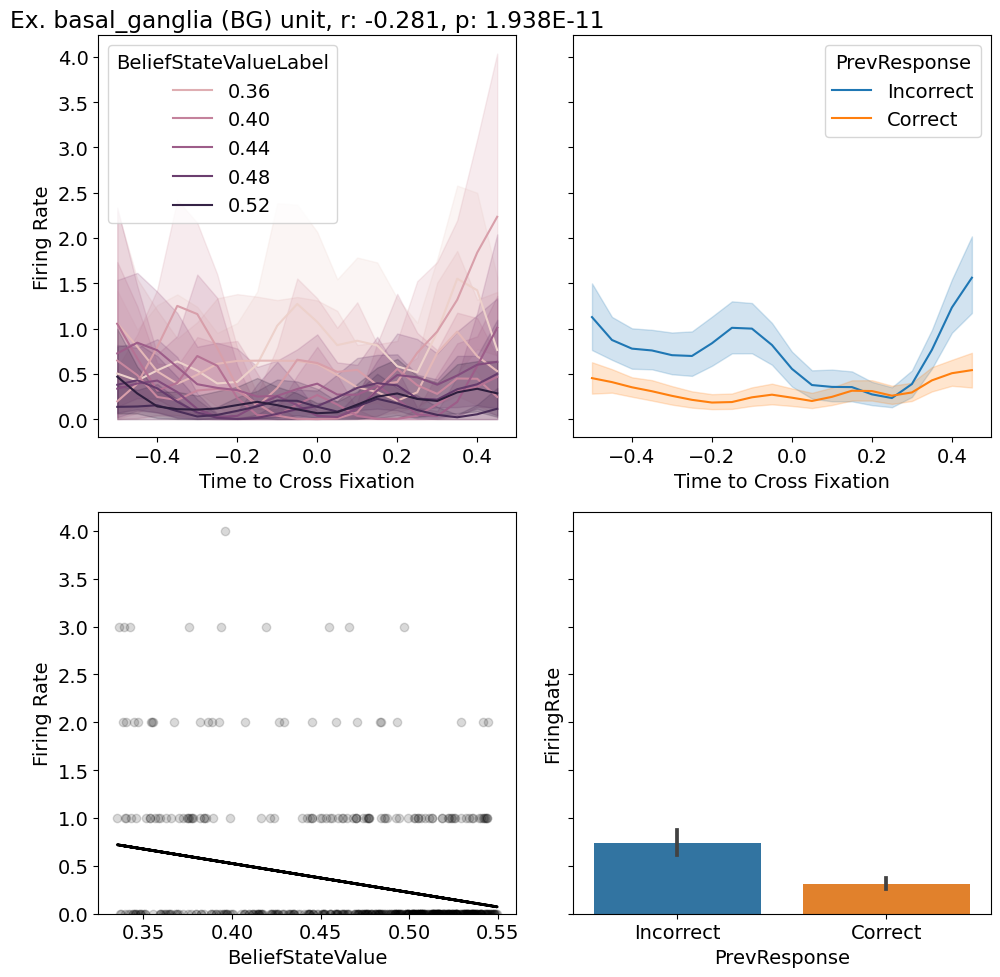

In [22]:
top = correlations.sort_values(by="r_mag", ascending=False)[:5]
for i, row in top.iterrows():
    visualize_correlations(row, prev_response_cond="Correct")

### Look at units with high correlation, conditioned on previous trial being incorrect

In [45]:
correlations = pd.read_pickle("/data/patrick_res/glm_2/belief_state_value_correlations_inc.pickle")
correlations = pd.merge(correlations, positions, on=["PseudoUnitID", "session", "UnitID"])
correlations["r_mag"] = correlations.r_value.abs()

In [46]:
correlations.sort_values(by="r_mag", ascending=False)[:5][["PseudoUnitID", "r_value", "structure_level2"]]

PseudoUnitID   r_value                     structure_level2
701    2018071247  0.280442                       amygdala (Amy)
668    2018071214 -0.267114  lateral_prefrontal_cortex (lat_PFC)
176    2018080611 -0.223766  lateral_prefrontal_cortex (lat_PFC)
515    2018100902 -0.214980      anterior_cingulate_gyrus (ACgG)
738    2018091012 -0.210530  lateral_prefrontal_cortex (lat_PFC)

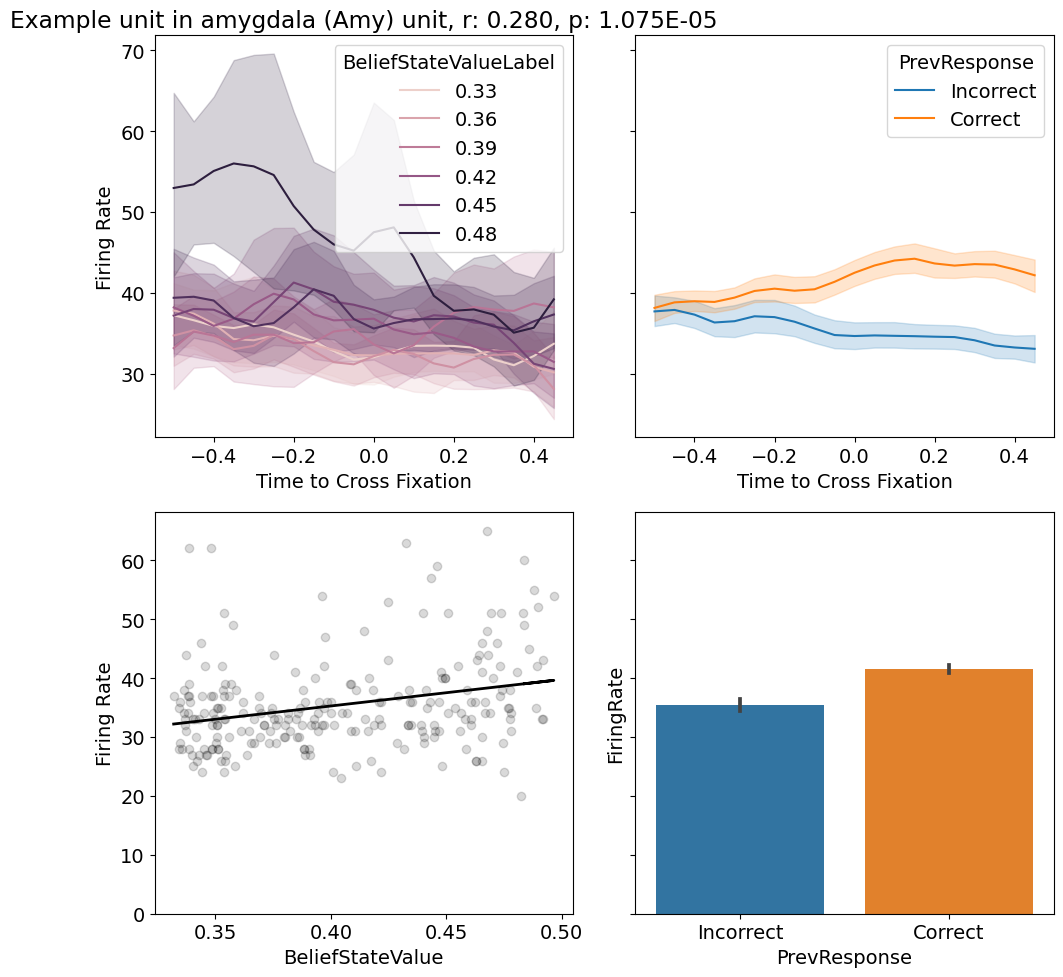

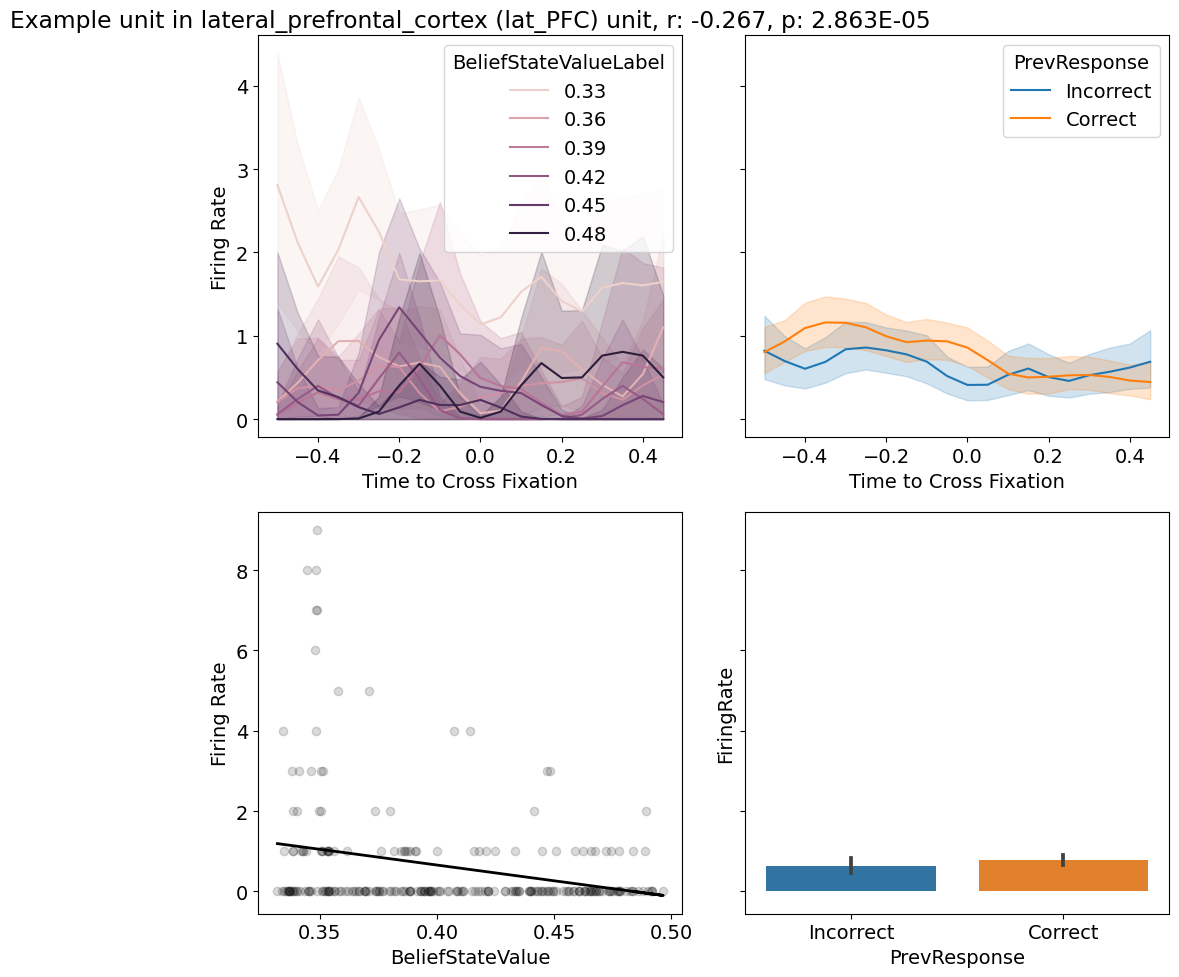

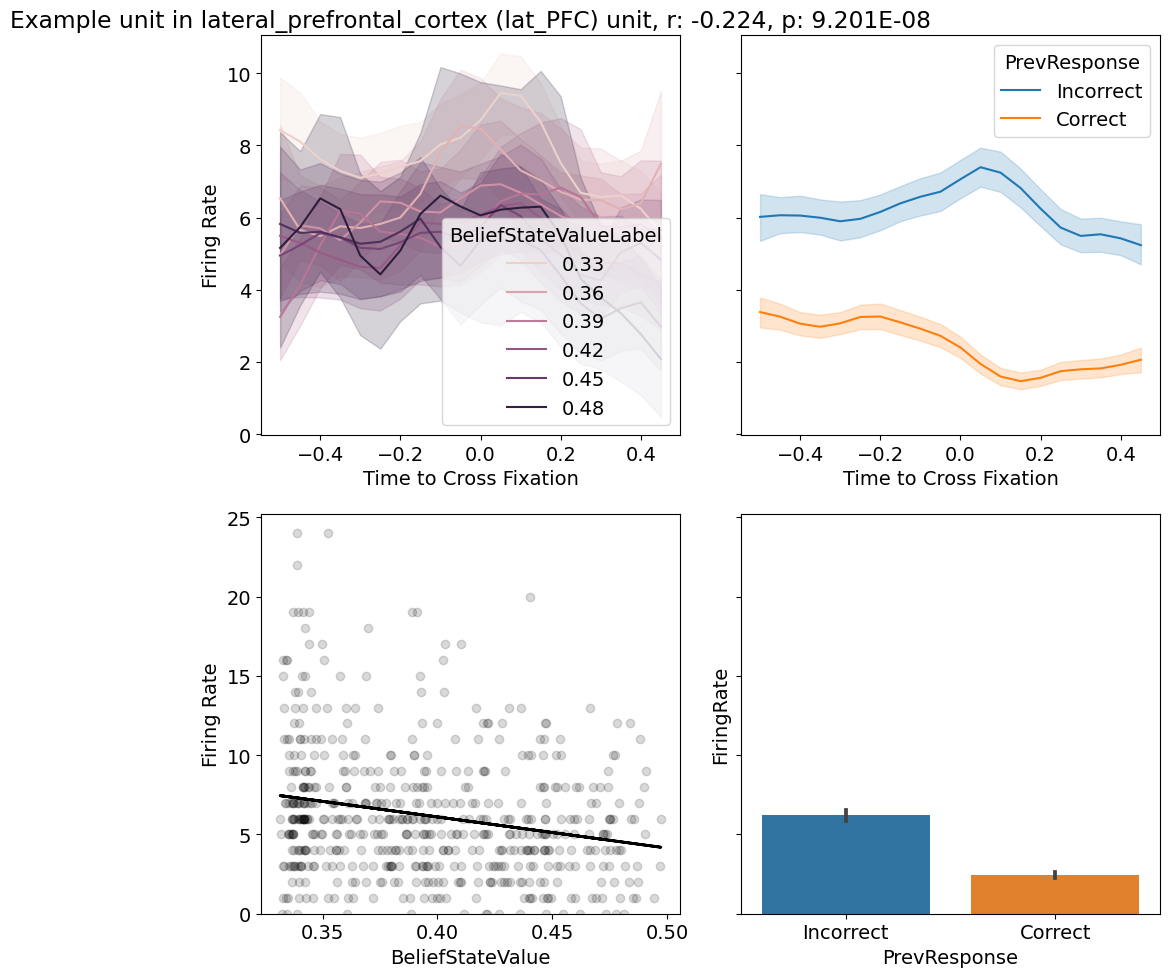

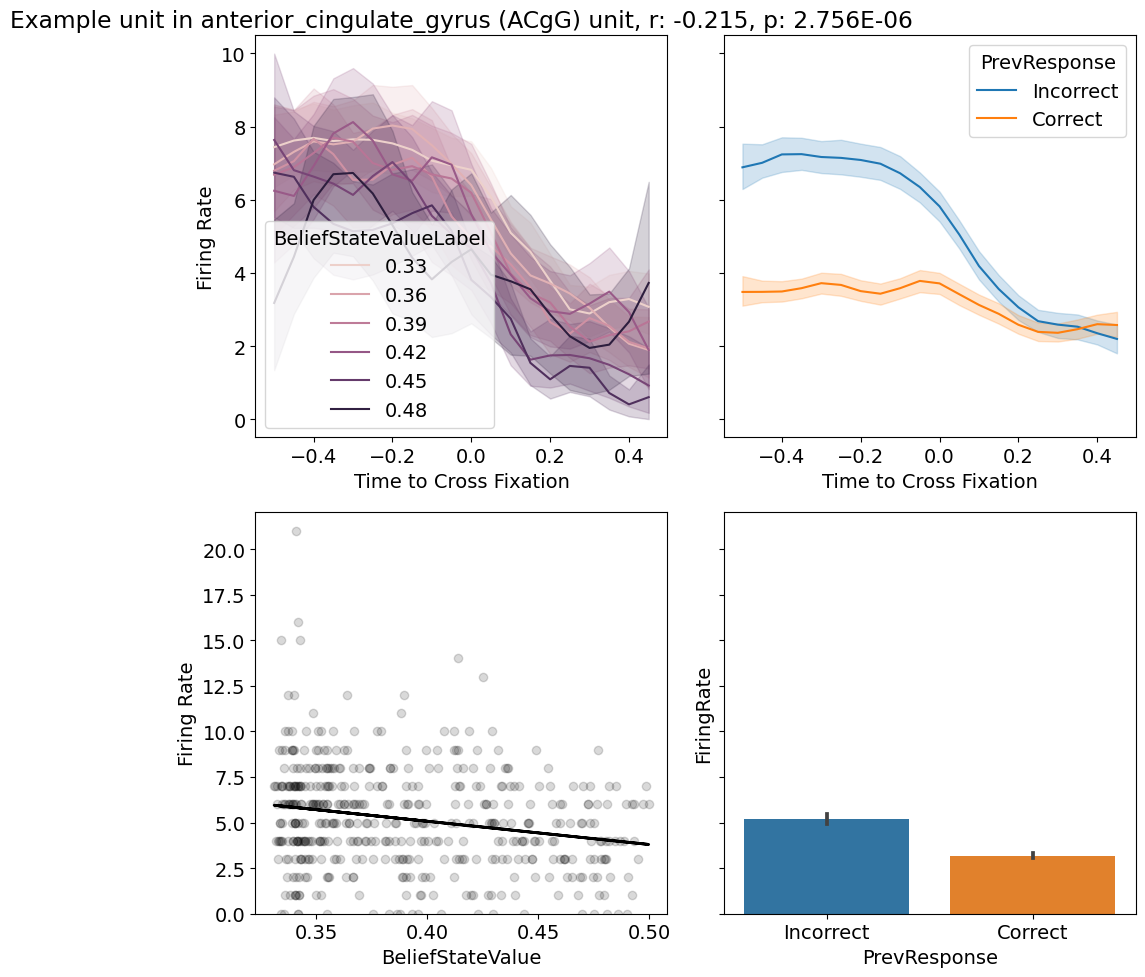

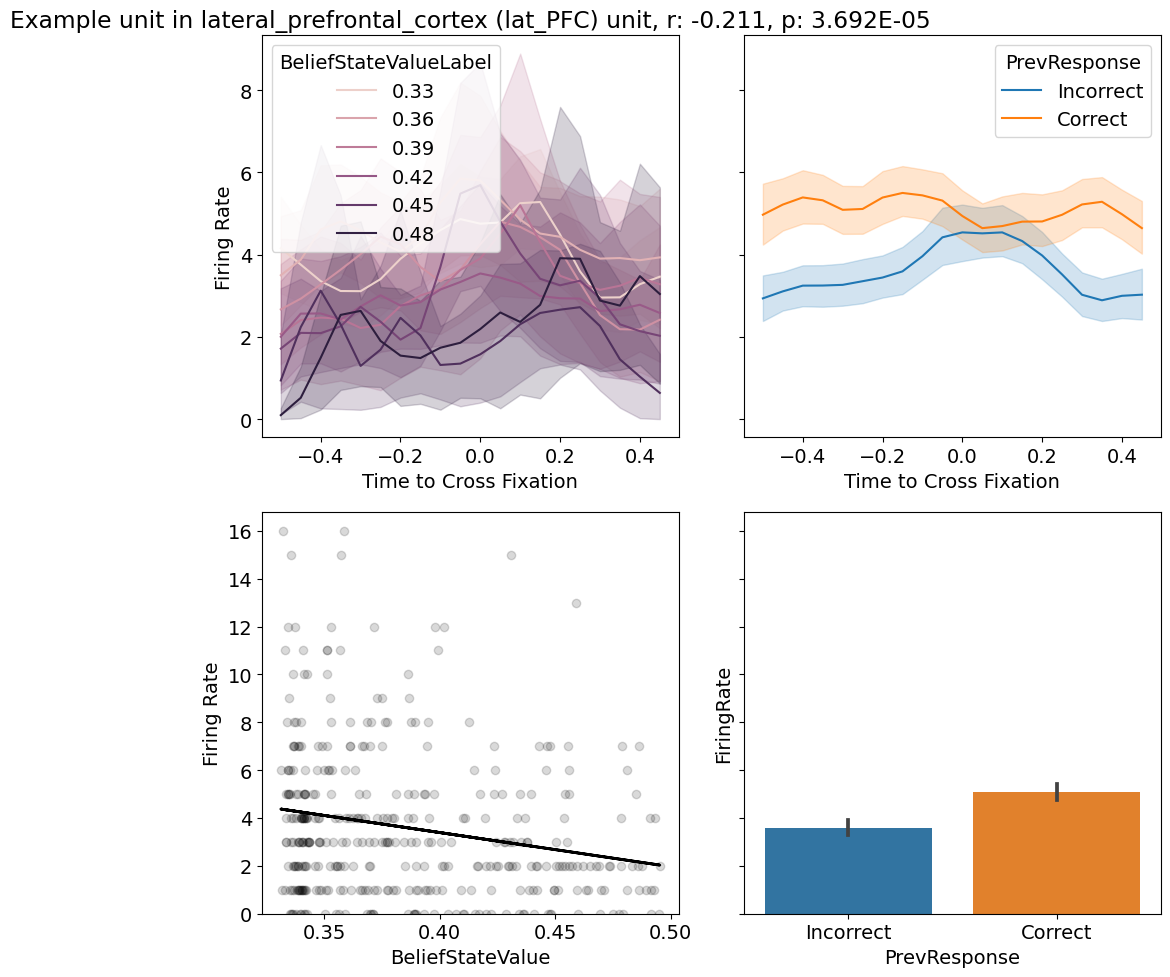

In [47]:
top = correlations.sort_values(by="r_mag", ascending=False)[:5]
for i, row in top.iterrows():
    visualize_correlations(row, prev_response_cond="Incorrect")

### Generate a combined figure for Cosyne 2025 Abstract

inferior_temporal_cortex (ITC)
basal_ganglia (BG)


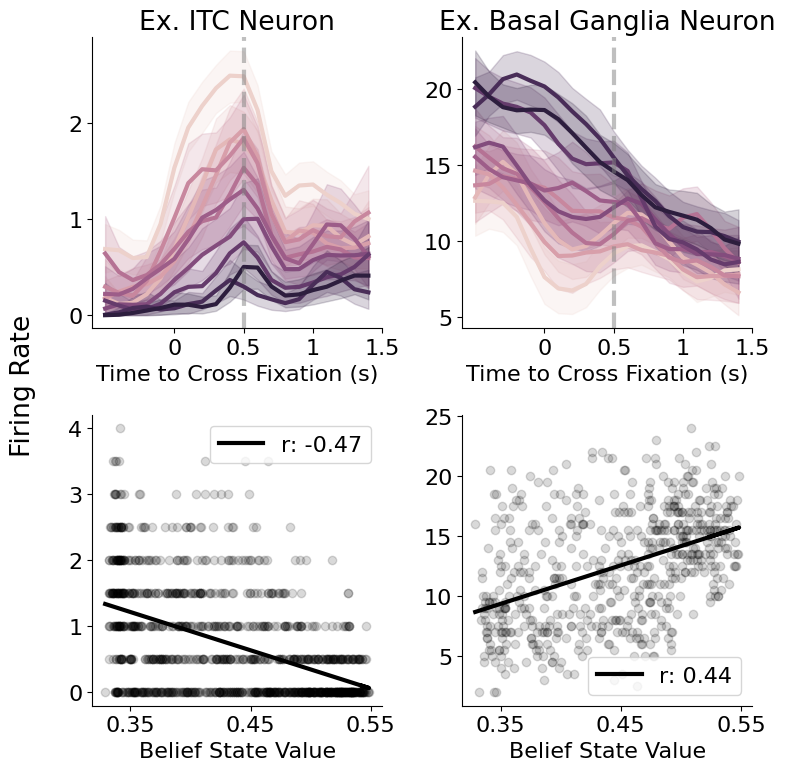

In [24]:
plt.rcParams.update({'font.size': 16})
# fig, axs = plt.subplots(2, 1, figsize=(4.5, 8), sharey=True)

correlations = pd.read_pickle("/data/patrick_res/glm_2/sa_belief_state_value_correlations_StimOnset.pickle")
SESSIONS_PATH = "/data/patrick_res/sessions/SA/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
positions = spike_utils.get_unit_positions(sessions)
correlations = pd.merge(correlations, positions, on=["PseudoUnitID", "session", "UnitID"])
correlations["r_mag"] = correlations.r_value.abs()
top = correlations.sort_values(by="r_mag", ascending=False)

interesting_units = [2018092006, 2018071202]
region_names = ["ITC", "Basal Ganglia"]

fig, axs = plt.subplots(2, 2, figsize=(8, 8))


for i, unit_id in enumerate(interesting_units):
    row = top[top.PseudoUnitID == unit_id].iloc[0]
    print(row.structure_level2)
    session = row.session

    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_beliefs_per_session(beh, session)
    # beh = behavioral_utils.get_prev_choice_fbs(beh)
    out, bins = pd.cut(beh["BeliefStateValue"], 10, labels=False, retbins=True)
    beh["BeliefStateValueBin"] = out
    beh["BeliefStateValueLabel"] = bins[out]

    # fr_path = f"/data/patrick_res/firing_rates/SA/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"

    fr_path = f"/data/patrick_res/firing_rates/SA/{session}_firing_rates_1000_StimOnset_1000_100_bins_{SMOOTH}_smooth.pickle"

    frs = pd.read_pickle(fr_path)
    frs = frs[frs.UnitID == row.UnitID]
    agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()

    ax = axs[0, i]
    sub_merged = pd.merge(frs, beh, on="TrialNumber")
    # sub_merged["Time to Cross Fixation"] = sub_merged["TimeBins"] - 0.5
    sub_merged["Time to Cross Fixation"] = sub_merged["TimeBins"] - 0.5

    sns.lineplot(sub_merged, x="Time to Cross Fixation", y="FiringRate", hue="BeliefStateValueLabel", linewidth=3, ax=ax)
    ax.get_legend().remove()
    # ax.set_ylabel("Firing Rate")
    ax.set_xlabel("Time to Cross Fixation (s)")
    ax.set_ylabel(None)
    ax.axvline(0.5, alpha=0.5, color='gray', linestyle='dashed', label="Stimulus Onset", linewidth=3)

    ax.set_xticks([0, .5, 1, 1.5])
    ax.set_xticklabels([0, .5, 1, 1.5])
    ax.spines[['right', 'top']].set_visible(False)

    ax = axs[1, i]
    sub_agg_merged = pd.merge(agg, beh, on="TrialNumber")
    slope, intercept, r_value, p_value, std_err = stats.linregress(sub_agg_merged["BeliefStateValue"], sub_agg_merged[mode])
    ax.scatter(sub_agg_merged["BeliefStateValue"], sub_agg_merged[mode], alpha=0.15, color="black")
    ax.plot(sub_agg_merged["BeliefStateValue"], sub_agg_merged["BeliefStateValue"] * slope + intercept, color="black", linewidth=3, label=f"r: {r_value:.2f}")
    ax.legend()
    ax.set_xticks([.35, .45, .55])
    ax.set_xticklabels([.35, .45, .55])
    ax.set_xlabel("Belief State Value")
    # ax.set_ylabel(f"Firing Rate")
    ax.spines[['right', 'top']].set_visible(False)

    axs[0, i].set_title(f"Ex. {region_names[i]} Neuron")
fig.supylabel("Firing Rate")
fig.tight_layout()
# fig.savefig("/data/patrick_res/figures/2025_cosyne_abstract/belief_state_value_single_unit.svg")
fig.savefig("/data/patrick_res/figures/2025_fadex_poster/belief_state_value_single_unit.svg")



### Look at Single units around FeedbackOnset

In [4]:
plt.rcParams.update({'font.size': 16})
# fig, axs = plt.subplots(2, 1, figsize=(4.5, 8), sharey=True)

correlations = pd.read_pickle("/data/patrick_res/glm_2/SA_belief_state_value_correlations_FeedbackOnset.pickle")
SESSIONS_PATH = "/data/patrick_res/sessions/SA/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
positions = spike_utils.get_unit_positions(sessions)
correlations = pd.merge(correlations, positions, on=["PseudoUnitID", "session", "UnitID"])
correlations["r_mag"] = correlations.r_value.abs()
top = correlations.sort_values(by="r_mag", ascending=False)

basal_ganglia (BG)
2018071202
amygdala (Amy)
2018092623


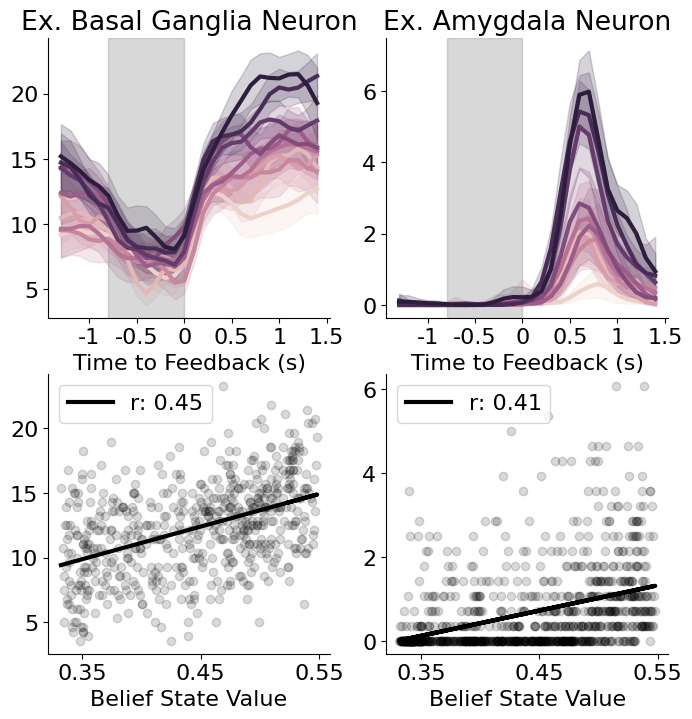

In [9]:
# interesting_units = top.PseudoUnitID.values[:10]
interesting_units = [2018071202, 2018092623]
region_names = ["Basal Ganglia", "Amygdala"]
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

for i, unit_id in enumerate(interesting_units):
    row = top[top.PseudoUnitID == unit_id].iloc[0]
    print(row.structure_level2)
    print(row.PseudoUnitID)
    session = row.session

    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_beliefs_per_session(beh, session)
    beh = behavioral_utils.shift_beliefs(beh)
    # beh = beh[beh.Response == "Correct"]
    
    out, bins = pd.cut(beh["BeliefStateValue"], 10, labels=False, retbins=True)
    beh["BeliefStateValueBin"] = out
    beh["BeliefStateValueLabel"] = bins[out]

    # fr_path = f"/data/patrick_res/firing_rates/SA/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"

    fr_path = f"/data/patrick_res/firing_rates/SA/{session}_firing_rates_1300_FeedbackOnset_1500_100_bins_1_smooth.pickle"

    frs = pd.read_pickle(fr_path)
    frs = frs[frs.UnitID == row.UnitID]
    agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()

    ax = axs[0, i]
    sub_merged = pd.merge(frs, beh, on="TrialNumber")
    # sub_merged["Time to Cross Fixation"] = sub_merged["TimeBins"] - 0.5
    sub_merged["Time to Feedback"] = sub_merged["TimeBins"] - 1.3

    sns.lineplot(sub_merged, x="Time to Feedback", y="FiringRate", hue="BeliefStateValueLabel", linewidth=3, ax=ax)
    ax.get_legend().remove()
    # ax.set_ylabel("Firing Rate")
    ax.set_xlabel("Time to Feedback (s)")
    ax.set_ylabel(None)
    # ax.axvline(0.5, alpha=0.5, color='gray', linestyle='dashed', label="Stimulus Onset", linewidth=3)

    ax.set_xticks([-1, -.5, 0, .5, 1, 1.5])
    ax.set_xticklabels([-1, -.5, 0, .5, 1, 1.5])
    ax.spines[['right', 'top']].set_visible(False)
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')

    ax = axs[1, i]
    sub_agg_merged = pd.merge(agg, beh, on="TrialNumber")
    slope, intercept, r_value, p_value, std_err = stats.linregress(sub_agg_merged["BeliefStateValue"], sub_agg_merged[mode])
    ax.scatter(sub_agg_merged["BeliefStateValue"], sub_agg_merged[mode], alpha=0.15, color="black")
    ax.plot(sub_agg_merged["BeliefStateValue"], sub_agg_merged["BeliefStateValue"] * slope + intercept, color="black", linewidth=3, label=f"r: {r_value:.2f}")
    ax.legend()
    ax.set_xticks([.35, .45, .55])
    ax.set_xticklabels([.35, .45, .55])
    ax.set_xlabel("Belief State Value")
    # ax.set_ylabel(f"Firing Rate")
    ax.spines[['right', 'top']].set_visible(False)

    axs[0, i].set_title(f"Ex. {region_names[i]} Neuron")
fig.savefig("/data/patrick_res/figures/2025_fadex_poster/belief_state_value_single_unit_fbonset.svg")
